In [ ]:
pip install snowflake-connector-python
pip install Prophet

In [32]:
import pandas as pd
import numpy as np
import snowflake.connector
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Collection 

### Connecting to Snowflake

In [4]:
import snowflake.connector
import pandas as pd


conn = snowflake.connector.connect(
    user='**',
    password='**',
    account='***',        
    warehouse='COMPUTE_WH',
    database='CIRCUS_OPS_REPORTING_LAYER',
    schema='CIRCUS_OPS_REPORTING_LAYER.RAW',
    role='TRANSFORM'       
)


cs = conn.cursor()
cs.execute("SELECT CURRENT_VERSION()")
print("Connected to Snowflake version:", cs.fetchone())


Connected to Snowflake version: ('9.30.0',)


### Pulling & aggregating the data

In [13]:
query = """
SELECT
    product_id,
    order_date,
    SUM(quantity) AS total_quantity
FROM CIRCUS_OPS_REPORTING_LAYER.RAW_CURATED.TBL_FACT_ORDER_PRODUCT
GROUP BY product_id, order_date
ORDER BY product_id, order_date
"""

df = pd.read_sql(query, conn)
print("✅ Data Loaded from Snowflake:", df.shape)



C:\Users\krish\AppData\Local\Temp\ipykernel_11040\3641824943.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Data Loaded from Snowflake: (2616, 3)


In [14]:
df.head()

,PRODUCT_ID,ORDER_DATE,TOTAL_QUANTITY
0,1,2024-10-03,10
1,1,2024-10-04,1
2,1,2024-10-05,7
3,1,2024-10-06,12
4,1,2024-10-07,1


# Preprocessing the Data

In [57]:
all_results = []

products = df['PRODUCT_ID'].unique()
forecast_horizon = 30  # days

for product in products:
    prod_df = df[df['PRODUCT_ID'] == product][['ORDER_DATE', 'TOTAL_QUANTITY']]
    prod_df = prod_df.rename(columns={'ORDER_DATE': 'ds', 'TOTAL_QUANTITY': 'y'}).sort_values('ds')

    # Fill missing dates with 0
    full_dates = pd.date_range(start=prod_df['ds'].min(), end=prod_df['ds'].max())
    prod_df = prod_df.set_index('ds').reindex(full_dates, fill_value=0).rename_axis('ds').reset_index()


# Model Budiling 

### Train/Test Split

In [52]:
train_size = int(len(prod_df) * 0.8)
train_df = prod_df.iloc[:train_size]
test_df = prod_df.iloc[train_size:]

### Fitting the model

In [55]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prod_df)

10:07:14 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing


#### Forecast on test + future period (30 days)

In [56]:
# Forecast for future horizon
future = model.make_future_dataframe(periods=forecast_horizon)
forecast = model.predict(future)

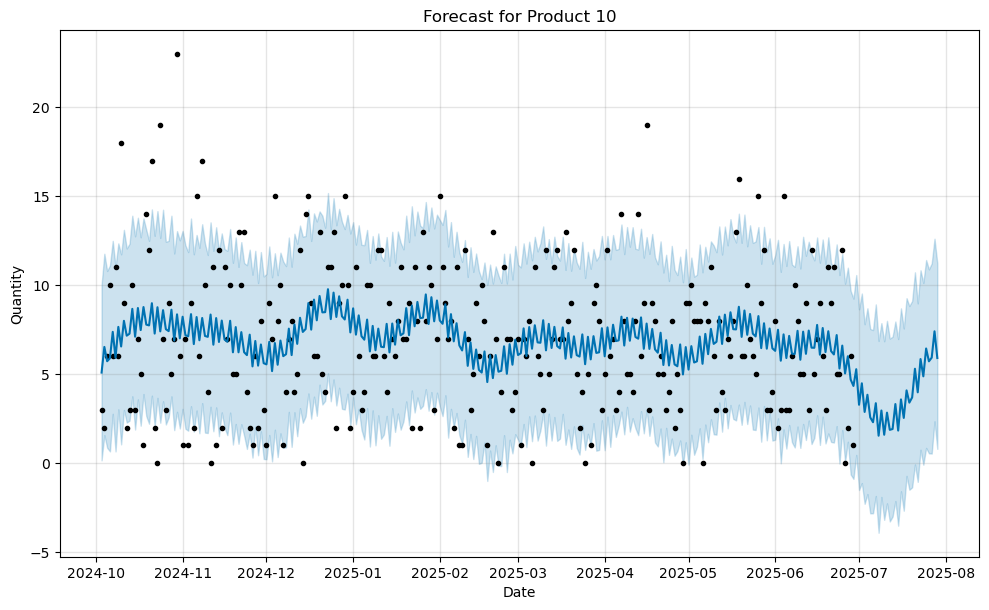

In [58]:

    # -----------------------------
    # Combine historical + forecast
    # -----------------------------
    combined = pd.DataFrame({
        'PRODUCT_ID': product,
        'FORECAST_DATE': forecast['ds'],
        'ACTUAL_QUANTITY': np.where(forecast['ds'].isin(prod_df['ds']), prod_df.set_index('ds')['y'].reindex(forecast['ds']).values, np.nan),
        'PREDICTED_QUANTITY': forecast['yhat']
    })

    all_results.append(combined)

    # Optional: plot
    model.plot(forecast)
    plt.title(f"Forecast for Product {product}")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.show()

# Model Evaluatation :  Forecast on Test Set

In [59]:
eval_df = forecast.set_index('ds').loc[test_df['ds']]
y_true = test_df['y'].values
y_pred = eval_df['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# sMAPE
smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

print(f"Product {product} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, sMAPE: {smape:.2f}%")

Product 10 - MAE: 2.94, RMSE: 3.48, sMAPE: 46.92%


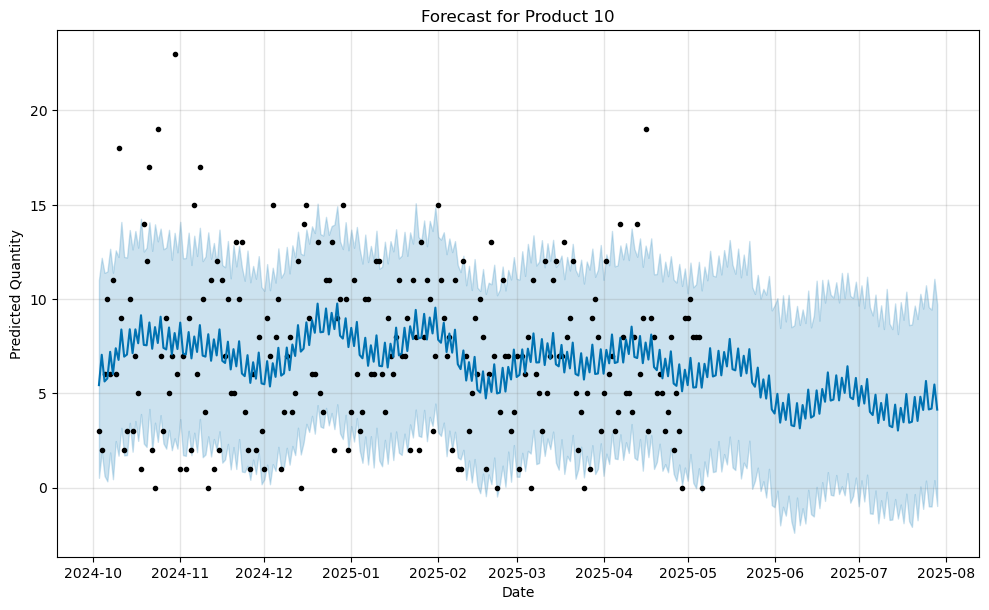

In [35]:
    # Step 7: Store forecast for future dates (30 days)
    # -----------------------------
    future_forecast = forecast.tail(30).copy()
    future_forecast['product_id'] = product
    all_forecasts.append(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'product_id']])

    # -----------------------------
    # Optional: Plot forecast
    # -----------------------------
    model.plot(forecast)
    plt.title(f"Forecast for Product {product}")
    plt.xlabel("Date")
    plt.ylabel("Predicted Quantity")
    plt.show()

# Combine all forecasts

In [63]:
from snowflake.connector.pandas_tools import write_pandas
final_forecast = pd.concat(all_forecasts)
final_forecast.rename(columns={'ds': 'forecast_date'}, inplace=True)


In [64]:
from snowflake.connector.pandas_tools import write_pandas

# Rename all columns to uppercase to match Snowflake table
final_forecast = final_forecast.rename(columns={
    'ds': 'FORECAST_DATE',
    'yhat': 'YHAT',
    'yhat_lower': 'YHAT_LOWER',
    'yhat_upper': 'YHAT_UPPER',
    'product_id': 'PRODUCT_ID'   # rename lowercase column to uppercase
})

# Create table with uppercase column names
cur = conn.cursor()
cur.execute("""
CREATE OR REPLACE TABLE CIRCUS_OPS_REPORTING_LAYER.SALES_FORECAST.PRODUCT_FORECAST (
    FORECAST_DATE TIMESTAMP_NTZ,
    PRODUCT_ID VARCHAR,
    YHAT FLOAT,
    YHAT_LOWER FLOAT,
    YHAT_UPPER FLOAT
)
""")

# Upload using write_pandas
success, nchunks, nrows, _ = write_pandas(
    conn,
    final_forecast,
    'PRODUCT_FORECAST',
    database='CIRCUS_OPS_REPORTING_LAYER',
    schema='SALES_FORECAST'
)

print(f"✅ Uploaded {nrows} rows to PRODUCT_FORECAST table")
cur.close()
conn.close()


DatabaseError: 250002 (08003): Connection is closed